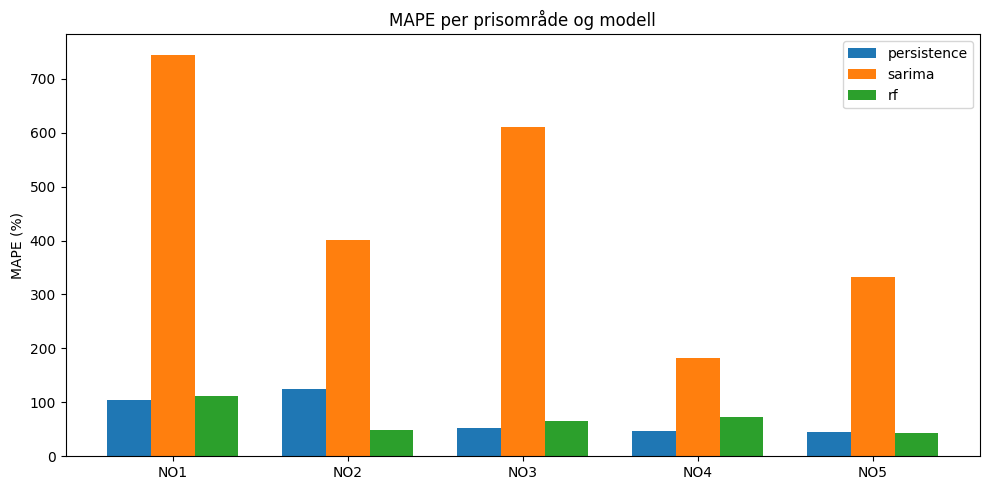

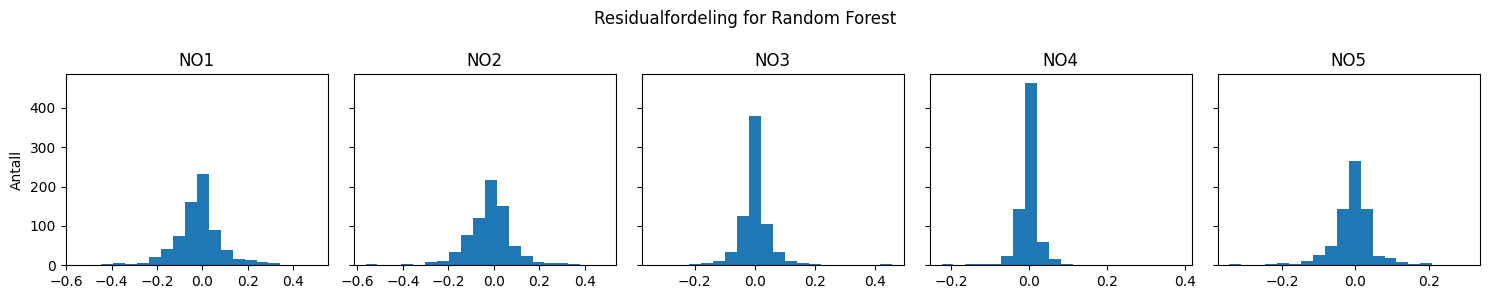

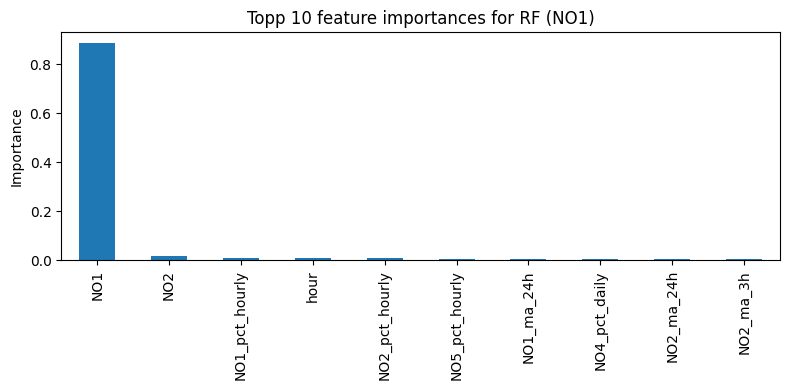

In [10]:
# notebooks/04_model_baseline_rf.ipynb

# 1) Setup imports og sti‐oppsett
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Anta at denne notebook kjører fra notebooks/-mappen
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
processed_dir = os.path.join(project_root, "data", "processed")

# 2) Last inn resultat‐CSVer
df_p = pd.read_csv(os.path.join(processed_dir, "persistence_zone_results.csv"), index_col=0)
df_s = pd.read_csv(os.path.join(processed_dir, "sarima_zone_results.csv"),        index_col=0)
df_rf= pd.read_csv(os.path.join(processed_dir, "rf_zone_results.csv"),             index_col=0)

# 3) Legg til modell‐navn
df_p["model"]  = "persistence"
df_s["model"]  = "sarima"
df_rf["model"] = "rf"

# 4) Kombiner til lang form
df_all = pd.concat([df_p, df_s, df_rf]).reset_index().rename(columns={"index":"zone"})

# 5) Barplot av MAPE per sone og modell
plt.figure(figsize=(10,5))
width = 0.25
zones = df_all.zone.unique()
x = np.arange(len(zones))
for i, m in enumerate(["persistence","sarima","rf"]):
    sub = df_all[df_all.model==m].set_index("zone").loc[zones]
    plt.bar(x + i*width, sub.MAPE, width=width, label=m)
plt.xticks(x + width, zones)
plt.ylabel("MAPE (%)")
plt.title("MAPE per prisområde og modell")
plt.legend()
plt.tight_layout()
plt.show()

# 6) Residual‐fordeling for RF
# Her gjenskaper vi X_test og y_test slik train_rf.py gjorde det, for å få residualer
# Last inn full sett med features/labels
X = pd.read_csv(os.path.join(processed_dir, "features.csv"), index_col=0)
X = X.replace([np.inf, -np.inf], np.nan).ffill().bfill()
y = pd.read_csv(os.path.join(processed_dir, "labels.csv"),   index_col=0)

# Split siste måned som test
test_size = 24 * 30
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

# Tren RF på nytt for å hente prediksjoner
# (alternativt kan du modifisere train_rf.py til å lagre prediksjons‐CSV)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
results_rf = {}
fig, axes = plt.subplots(1, len(zones), figsize=(15,3), sharey=True)
for i, zone in enumerate(zones):
    # Tren på hele treningsdata (X uten de siste test_size rader)
    X_train = X.iloc[:-test_size]
    y_train = y.iloc[:-test_size]
    rf.fit(X_train, y_train[f"{zone}_label"])
    preds = rf.predict(X_test)
    residuals = y_test[f"{zone}_label"].values - preds
    axes[i].hist(residuals, bins=20)
    axes[i].set_title(zone)
axes[0].set_ylabel("Antall")
plt.suptitle("Residualfordeling for Random Forest")
plt.tight_layout()
plt.show()

# 7) Feature importances for NO1 som eksempel
rf.fit(X_train, y_train["NO1_label"])
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
importances.head(10).plot(kind="bar")
plt.title("Topp 10 feature importances for RF (NO1)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [11]:
# 8) Hyperparametertuning med GridSearchCV
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import os

# Hent data og split
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
processed_dir = os.path.join(project_root, "data", "processed")

X = pd.read_csv(os.path.join(processed_dir, "features.csv"), index_col=0)
X = X.replace([np.inf, -np.inf], np.nan).ffill().bfill()
y = pd.read_csv(os.path.join(processed_dir, "labels.csv"), index_col=0)

# Del siste måned (30 dager) som testsett
test_size = 24 * 30
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

zones = [c.replace("_label","") for c in y.columns]

# Definer parametergrid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2, 5]
}

# TimeSeries-splitt
tscv = TimeSeriesSplit(n_splits=3)

results = []
for zone in zones:
    print(f"Running grid search for {zone}…")
    rf = RandomForestRegressor(random_state=42)
    gs = GridSearchCV(
        rf,
        param_grid,
        cv=tscv,
        scoring="neg_mean_absolute_percentage_error",
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train[f"{zone}_label"])
    
    best = gs.best_params_
    cv_score = -gs.best_score_
    
    # Evaluer på testsett
    preds = gs.predict(X_test)
    test_mape = mean_absolute_percentage_error(y_test[f"{zone}_label"], preds) * 100
    
    results.append({
        "zone": zone,
        "n_estimators": best["n_estimators"],
        "max_depth": best["max_depth"],
        "min_samples_leaf": best["min_samples_leaf"],
        "cv_MAPE_%": cv_score * 100,
        "test_MAPE_%": test_mape
    })

# Lag DataFrame og skriv til disk
df_grid = pd.DataFrame(results).set_index("zone")
df_grid.to_csv(os.path.join(processed_dir, "rf_grid_search_zone_results.csv"))
print("Grid-search fullført og resultater lagret i rf_grid_search_zone_results.csv")


Running grid search for NO1…
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Running grid search for NO2…
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Running grid search for NO3…
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Running grid search for NO4…
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Running grid search for NO5…
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Grid-search fullført og resultater lagret i rf_grid_search_zone_results.csv


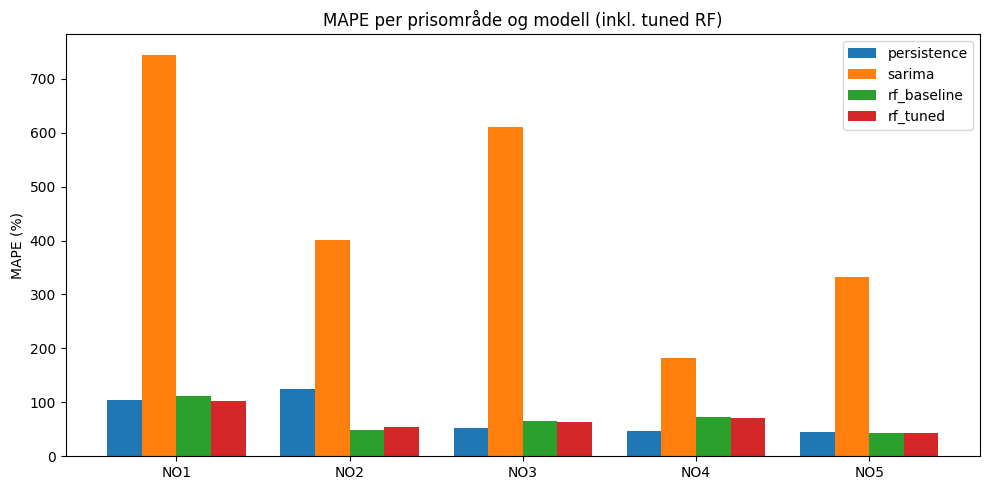

In [12]:
# ─── 8) Last inn tuned-RF resultater ─────────────────────────────────────────────
import pandas as pd

processed_dir = os.path.join(project_root, "data", "processed")

# Hent tuned results
df_tuned = pd.read_csv(
    os.path.join(processed_dir, "rf_tuned_final_results.csv"),
    index_col=0
)
df_tuned = df_tuned.rename_axis("zone").reset_index()
df_tuned["model"] = "rf_tuned"
df_tuned = df_tuned.rename(columns={"MAPE_%": "MAPE"})

# Hent baseline RF på samme format
df_rf_base = df_rf.reset_index().rename(columns={"index":"zone","MAPE":"MAPE"})
df_rf_base["model"] = "rf_baseline"

# Hent persistence og SARIMA fra df_p og df_s (hvis du har dem på hånd)
df_p2 = df_p.reset_index().rename(columns={"index":"zone"})
df_s2 = df_s.reset_index().rename(columns={"index":"zone"})

# Slå sammen alle
df_all2 = pd.concat([
    df_p2[["zone","MAPE"]].assign(model="persistence"),
    df_s2[["zone","MAPE"]].assign(model="sarima"),
    df_rf_base[["zone","MAPE"]].assign(model="rf_baseline"),
    df_tuned[["zone","MAPE"]].assign(model="rf_tuned"),
]).reset_index(drop=True)

# ─── 9) Barplot med tuned RF ─────────────────────────────────────────────────────
plt.figure(figsize=(10,5))
width = 0.2
zones = df_all2.zone.unique()
x = np.arange(len(zones))

for i, m in enumerate(["persistence","sarima","rf_baseline","rf_tuned"]):
    sub = df_all2[df_all2.model==m].set_index("zone").loc[zones]
    plt.bar(x + i*width, sub.MAPE, width=width, label=m)

plt.xticks(x + 1.5*width, zones)
plt.ylabel("MAPE (%)")
plt.title("MAPE per prisområde og modell (inkl. tuned RF)")
plt.legend()
plt.tight_layout()
plt.show()


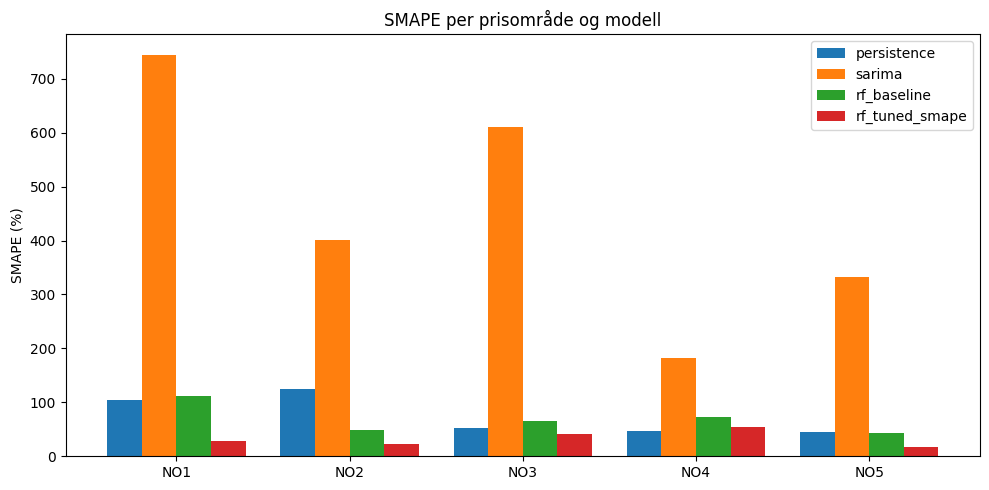

In [13]:
# ─── 8) Last inn tuned-RF SMAPE-resultater ──────────────────────────────────────
import os
import pandas as pd

# forutsetter at project_root og processed_dir allerede er definert
smape_path = os.path.join(processed_dir, "rf_tuned_final_results_smape.csv")
df_tuned = pd.read_csv(smape_path, index_col=0).reset_index().rename(columns={"index":"zone"})
df_tuned["model"] = "rf_tuned_smape"
df_tuned = df_tuned.rename(columns={"SMAPE_%": "Error"})

# Hent baseline RF-MAPE og presenter som «Error» for å sammenligne direkte på SMAPE
df_rf_base = df_rf.reset_index().rename(columns={"index":"zone","MAPE":"Error"})
df_rf_base["model"] = "rf_baseline"

# Persistence og SARIMA: slå om kolonnenavn til «Error» også
df_p2 = df_p.reset_index().rename(columns={"index":"zone","MAPE":"Error"})
df_p2["model"] = "persistence"
df_s2 = df_s.reset_index().rename(columns={"index":"zone","MAPE":"Error"})
df_s2["model"] = "sarima"

# Slå sammen alle
df_all2 = pd.concat([
    df_p2[["zone","Error","model"]],
    df_s2[["zone","Error","model"]],
    df_rf_base[["zone","Error","model"]],
    df_tuned[["zone","Error","model"]],
], ignore_index=True)

# ─── 9) Barplot av SMAPE ────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
width = 0.2
zones = df_all2.zone.unique()
x = np.arange(len(zones))

for i, m in enumerate(["persistence","sarima","rf_baseline","rf_tuned_smape"]):
    sub = df_all2[df_all2.model==m].set_index("zone").loc[zones]
    plt.bar(x + i*width, sub.Error, width=width, label=m)

plt.xticks(x + 1.5*width, zones)
plt.ylabel("SMAPE (%)")
plt.title("SMAPE per prisområde og modell")
plt.legend()
plt.tight_layout()
plt.show()


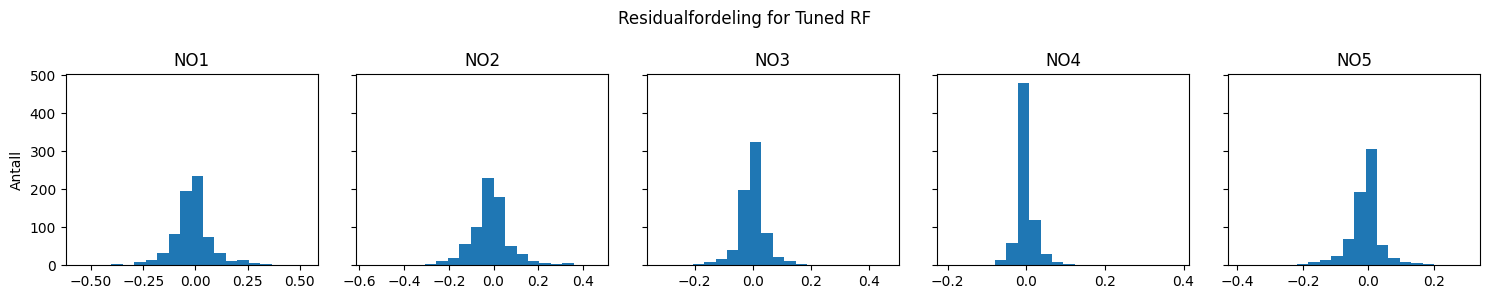

In [14]:
import joblib

fig, axes = plt.subplots(1, len(zones), figsize=(15,3), sharey=True)
for i, zone in enumerate(zones):
    rf = joblib.load(f"../src/models/rf_tuned_models/rf_tuned_{zone}.joblib")
    preds = rf.predict(X_test)
    residuals = y_test[f"{zone}_label"].values - preds
    axes[i].hist(residuals, bins=20)
    axes[i].set_title(zone)
axes[0].set_ylabel("Antall")
plt.suptitle("Residualfordeling for Tuned RF")
plt.tight_layout()
plt.show()


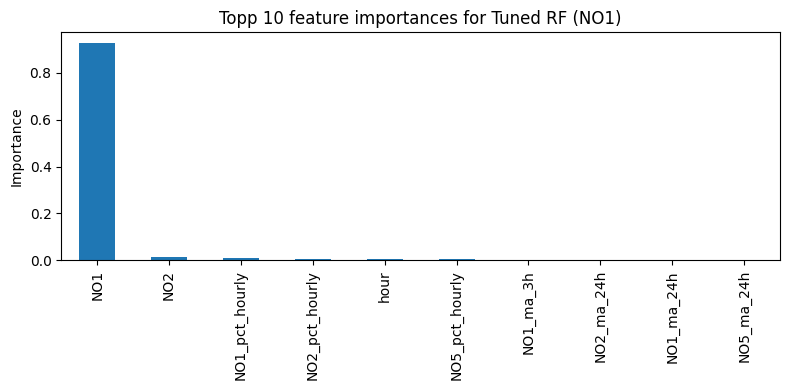

In [16]:
rf = joblib.load("../src/models/rf_tuned_models/rf_tuned_NO1.joblib")
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
importances.head(10).plot(kind="bar")
plt.title("Topp 10 feature importances for Tuned RF (NO1)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


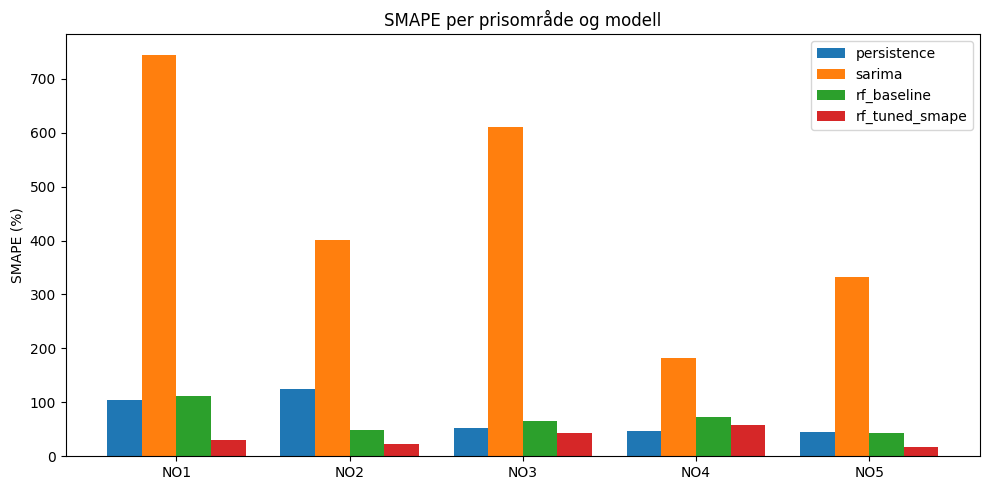

In [17]:
# ─── Last inn tuned‐RF SMAPE‐resultater ────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Forutsetter at processed_dir og df_p, df_s, df_rf_base finnes
smape_csv = os.path.join(processed_dir, "rf_tuned_final_results_smape.csv")
df_tuned  = pd.read_csv(smape_csv, index_col=0).reset_index().rename(columns={"index":"zone"})
df_tuned["model"] = "rf_tuned_smape"
df_tuned = df_tuned.rename(columns={"SMAPE_%": "Error"})

# Hent baseline RF-MAPE og kall kolonnen «Error» også, for direkte sammenligning
df_rf_base2 = df_rf.reset_index().rename(columns={"index":"zone","MAPE":"Error"})
df_rf_base2["model"] = "rf_baseline"

# Persistence og SARIMA: rename kolonne til «Error»
df_p2 = df_p.reset_index().rename(columns={"index":"zone","MAPE":"Error"})
df_p2["model"] = "persistence"
df_s2 = df_s.reset_index().rename(columns={"index":"zone","MAPE":"Error"})
df_s2["model"] = "sarima"

# Kombiner alle til ett DataFrame
df_all = pd.concat([df_p2[["zone","Error","model"]],
                    df_s2[["zone","Error","model"]],
                    df_rf_base2[["zone","Error","model"]],
                    df_tuned[["zone","Error","model"]]],
                   ignore_index=True)

# ─── Plot SMAPE for alle modeller ────────────────────────────────────────────────
plt.figure(figsize=(10,5))
width = 0.2
zones = df_all.zone.unique()
x = np.arange(len(zones))
for i, m in enumerate(["persistence","sarima","rf_baseline","rf_tuned_smape"]):
    sub = df_all[df_all.model==m].set_index("zone").loc[zones]
    plt.bar(x + i*width, sub.Error, width=width, label=m)
plt.xticks(x + 1.5*width, zones)
plt.ylabel("SMAPE (%)")
plt.title("SMAPE per prisområde og modell")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
#!/usr/bin/env python3
# src/models/train_tuned_rf_smape.py

import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib


def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Symmetric Mean Absolute Percentage Error (SMAPE) i %.
    """
    eps = 1e-6
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)


def main():
    # Paths
    BASE_DIR =  os.path.abspath(os.path.join(os.getcwd(), ".."))
    proc_dir = os.path.join(BASE_DIR, "data", "processed")
    features_path = os.path.join(proc_dir, "features.csv")
    labels_path = os.path.join(proc_dir, "labels.csv")
    grid_path = os.path.join(proc_dir, "rf_grid_search_zone_results.csv")
    output_csv = os.path.join(proc_dir, "rf_tuned_final_results_smape.csv")

    model_dir = os.path.join(BASE_DIR, "src", "models", "rf_tuned_models")
    os.makedirs(model_dir, exist_ok=True)

    # Load data
    X = pd.read_csv(features_path, index_col=0)
    y = pd.read_csv(labels_path, index_col=0)

    # Split last month as test
    test_size = 24 * 30
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

    # Clean inf and missing
    for df in (X_train, X_test):
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method="ffill", inplace=True)
        df.fillna(method="bfill", inplace=True)

    # Ensure X_test has same columns/order as X_train
    X_test = X_test[X_train.columns]

    # Load tuned params
    grid = pd.read_csv(grid_path, index_col="zone")

    results = {}
    for zone, params in grid.iterrows():
        print(f"Training zone {zone} with params: {params.to_dict()}")
        n_est = int(params.n_estimators)
        max_d = None if pd.isna(params.max_depth) else int(params.max_depth)
        min_leaf = int(params.min_samples_leaf)

        rf = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_d,
            min_samples_leaf=min_leaf,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train[f"{zone}_label"])

        # Predict using numpy array to avoid feature name mismatch
        preds = rf.predict(X_test.values)
        true = y_test[f"{zone}_label"].values
        mask = ~np.isnan(true)

        mae = mean_absolute_error(true[mask], preds[mask])
        rmse = np.sqrt(mean_squared_error(true[mask], preds[mask]))
        smape_val = smape(true[mask], preds[mask])

        results[zone] = {"MAE": mae, "RMSE": rmse, "SMAPE_%": smape_val}

        # Save model
        model_file = os.path.join(model_dir, f"rf_tuned_{zone}.joblib")
        joblib.dump(rf, model_file)
        print(f"Saved model for zone {zone} to {model_file}")

    # Write results
    df_final = pd.DataFrame(results).T
    df_final.to_csv(output_csv)
    print(f"SMAPE results saved to {output_csv}")

if __name__ == "__main__":
    main()


C:\Users\ofssuksr\AppData\Local\Temp\ipykernel_15708\1974686574.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\ofssuksr\AppData\Local\Temp\ipykernel_15708\1974686574.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\Users\ofssuksr\AppData\Local\Temp\ipykernel_15708\1974686574.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method="ffill", inplace=True)
C:\Users\ofssuksr\AppData\Local\Temp\ipykernel_1570

Training zone NO1 with params: {'n_estimators': 200.0, 'max_depth': 10.0, 'min_samples_leaf': 5.0, 'cv_MAPE_%': 28878629360687.58, 'test_MAPE_%': 174450026160905.38}


C:\Users\ofssuksr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Saved model for zone NO1 to C:\AibelProgs\side prosjekt\Electricity-forecast\src\models\rf_tuned_models\rf_tuned_NO1.joblib
Training zone NO2 with params: {'n_estimators': 50.0, 'max_depth': 10.0, 'min_samples_leaf': 5.0, 'cv_MAPE_%': 57265880748119.375, 'test_MAPE_%': 259361494471267.56}


C:\Users\ofssuksr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Saved model for zone NO2 to C:\AibelProgs\side prosjekt\Electricity-forecast\src\models\rf_tuned_models\rf_tuned_NO2.joblib
Training zone NO3 with params: {'n_estimators': 200.0, 'max_depth': nan, 'min_samples_leaf': 5.0, 'cv_MAPE_%': 28726556257520.508, 'test_MAPE_%': 98377948275182.44}


C:\Users\ofssuksr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Saved model for zone NO3 to C:\AibelProgs\side prosjekt\Electricity-forecast\src\models\rf_tuned_models\rf_tuned_NO3.joblib
Training zone NO4 with params: {'n_estimators': 50.0, 'max_depth': 10.0, 'min_samples_leaf': 5.0, 'cv_MAPE_%': 46832043677178.76, 'test_MAPE_%': 281971875325146.8}


C:\Users\ofssuksr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Saved model for zone NO4 to C:\AibelProgs\side prosjekt\Electricity-forecast\src\models\rf_tuned_models\rf_tuned_NO4.joblib
Training zone NO5 with params: {'n_estimators': 50.0, 'max_depth': 10.0, 'min_samples_leaf': 1.0, 'cv_MAPE_%': 40723728830685.11, 'test_MAPE_%': 178850262081571.66}
Saved model for zone NO5 to C:\AibelProgs\side prosjekt\Electricity-forecast\src\models\rf_tuned_models\rf_tuned_NO5.joblib
SMAPE results saved to C:\AibelProgs\side prosjekt\Electricity-forecast\data\processed\rf_tuned_final_results_smape.csv


C:\Users\ofssuksr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
